# Customer Churn Prediction

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from inspect import signature
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Helpers
def print_results(actual, pred):
    y_preds = (pred > 0.5).astype(int)
    print('Confusion matrix:')
    print(metrics.confusion_matrix(actual, y_preds))
    print('Accuracy: {:.2f}%'.format(metrics.accuracy_score(actual, y_preds) * 100))
    print('Precision: {:.2f}%'.format(metrics.precision_score(actual, y_preds) * 100))
    print('Recall: {:.2f}%'.format(metrics.recall_score(actual, y_preds) * 100))
    print('F1 score: {:.2f}%'.format(metrics.f1_score(actual, y_preds) * 100))


# ROC(tpr-fpr) curve
def plot_roc_curve(actual, pred):
    """Plot ROC."""
    fpr, tpr, _ = metrics.roc_curve(actual, pred)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC AUC = {:.4f}'.format(
        metrics.roc_auc_score(actual, pred)))
    return fig


# Precision-recall curve
def plot_pr_curve(actual, pred):
    """Plot PR curve."""
    precision, recall, _ = metrics.precision_recall_curve(actual, pred)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    fig, ax = plt.subplots()
    ax.step(recall, precision, color='b', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Avg precision = {:.4f}'.format(
        metrics.average_precision_score(actual, pred)))
    return fig

# pd.set_option('display.max_columns', 500)

## EDA - data deepdive

The first task in any data science or ML project is to understand and clean the data.

- Understand the data types for each feature
- Look for anomalies and missing values
- Understand the distributions for each feature

In [43]:
subscribers = pd.read_parquet('data/subscribers.gz.parquet', engine='fastparquet')
subscribers["Churn"] = (~subscribers["Date_Closed"].isnull()).astype(int)
subscribers.head()

,User_id,State,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,CustServ_Calls,Date_Created,Date_Closed,Churn
0,cfcd208495d565ef66e7dff9f98764da,KS,415,382-4657,no,yes,25,1,2017-07-26,None,0
1,c4ca4238a0b923820dcc509a6f75849b,OH,415,371-7191,no,yes,26,1,2017-08-16,None,0
2,c81e728d9d4c2f636f067f89cc14862c,NJ,415,358-1921,no,no,0,0,2017-07-17,None,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,OH,408,375-9999,yes,no,0,2,2017-09-08,None,0
4,a87ff679a2f3e71d9181a67b7542122c,OK,415,330-6626,yes,no,0,3,2017-09-17,None,0


In [33]:
subscribers.describe()

,Area_Code,VMail_Message,CustServ_Calls
count,3333.000000,3333.000000,3333.000000
mean,437.182418,8.099010,1.562856
std,42.371290,13.688365,1.315491
min,408.000000,0.000000,0.000000
25%,408.000000,0.000000,1.000000
50%,415.000000,0.000000,1.000000
75%,510.000000,20.000000,2.000000
max,510.000000,51.000000,9.000000


In [48]:
vcount = subscribers['State'].value_counts().reset_index()
vcount.columns = ['State', 'Total']

vcount2 = subscribers['State'].loc[subscribers['Churn']==1].value_counts().reset_index()
vcount2.columns = ['State', 'Left']

vcount = pd.merge(vcount, vcount2, on=['State'])
vcount = vcount.fillna(0)
vcount.head()

,State,Total,Left
0,WV,106,10
1,MN,84,15
2,NY,83,15
3,AL,80,8
4,OR,78,11


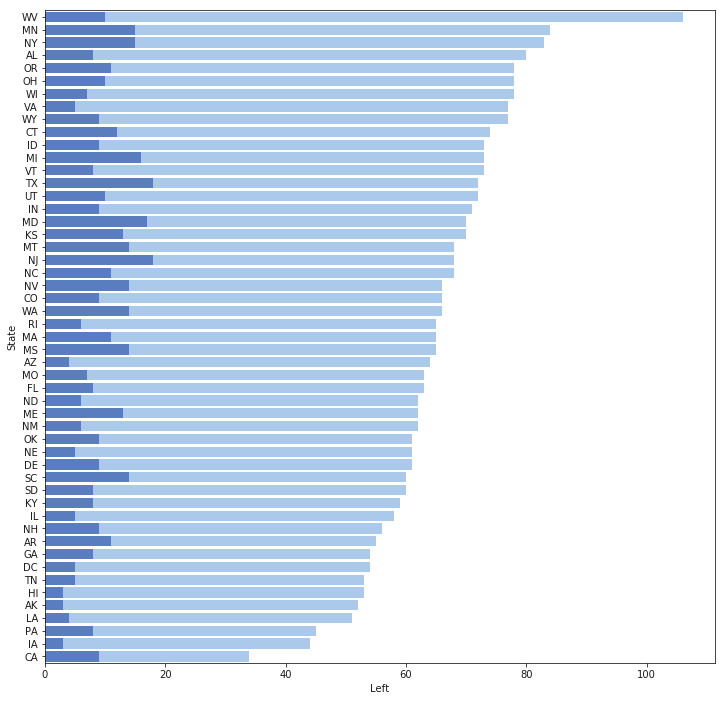

In [49]:
plt.figure(figsize=(12, 12))
sns.set_color_codes("pastel")
sns.barplot(x="Total", y="State", data=vcount, color="b")

sns.set_color_codes("muted")
sns.barplot(x="Left", y="State", data=vcount, color="b")
plt.show()

In [51]:
all_calls = pd.read_parquet('data/all_calls.gz.parquet', engine='fastparquet')
all_calls.head()

,User_id,Duration,Call_type
0,6766aa2750c19aad2fa1b32f36ed4aee,1.451465,Day
1,8fe0093bb30d6f8c31474bd0764e6ac0,0.318914,Eve
2,0234c510bc6d908b28c70ff313743079,2.111892,Day
3,dba132f6ab6a3e3d17a8d59e82105f4c,3.305193,Eve
4,d542599794c1cf067d90638b5d3911f3,1.924791,Night


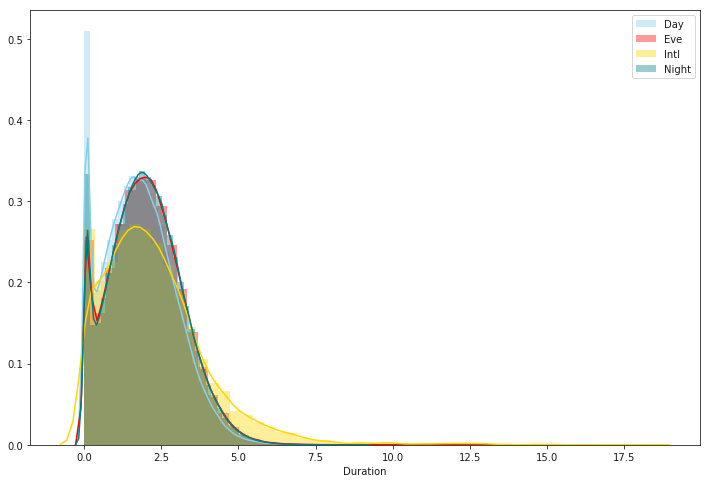

In [56]:
plt.figure(figsize=(12, 8))
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Day"], color="skyblue", label="Day")
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Eve"], color="red", label="Eve")
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Intl"], color="gold", label="Intl")
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Night"], color="teal", label="Night")
plt.legend()
plt.show()

## Feature engineering

One can increase the predictive quality of the data and reduce dimensionality using feature engineering.

- Feature crosses
- Embeddings
- PCA
- Categorical encoding

For example, we shall perform one-hot encoding on `Area_Code` and `State`.

In [32]:
subscribers['Area_Code'].unique()

array([415, 408, 510])

In [154]:
subscribers['State'].unique()

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

## Preprocessing

In [5]:
subscribers["Churn"] = (~subscribers["Date_Closed"].isnull()).astype(int)
subscribers = subscribers.drop(['Date_Created', 'Date_Closed', 'Phone'], axis=1)
subscribers.head()

,User_id,State,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,CustServ_Calls,Churn
0,cfcd208495d565ef66e7dff9f98764da,KS,415,no,yes,25,1,0
1,c4ca4238a0b923820dcc509a6f75849b,OH,415,no,yes,26,1,0
2,c81e728d9d4c2f636f067f89cc14862c,NJ,415,no,no,0,0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,OH,408,yes,no,0,2,0
4,a87ff679a2f3e71d9181a67b7542122c,OK,415,yes,no,0,3,0


In [4]:
all_calls = all_calls.groupby(['Call_type', 'User_id']).agg(['sum', 'count']).reset_index()
all_calls.columns = ['Call_type', 'User_id', 'Mins', 'Calls']
all_calls = all_calls.pivot(index='User_id', columns='Call_type', values=['Mins', 'Calls']).reset_index()
all_calls.columns = ['User_id', 'Day Mins', 'Eve Mins', 'Intl Mins', 'Night Mins',
                     'Day Calls', 'Eve Calls', 'Intl Calls', 'Night Calls']

all_calls.head()

,User_id,Day Mins,Eve Mins,Intl Mins,Night Mins,Day Calls,Eve Calls,Intl Calls,Night Calls
0,0004d0b59e19461ff126e3a08a814c33,167.800003,212.900009,13.0,208.199997,121.0,123.0,3.0,73.0
1,00411460f7c92d2124a67ea0f4cb5f85,230.000000,103.199997,11.3,309.600006,87.0,138.0,3.0,136.0
2,006f52e9102a8d3be2fe5614f42ba989,170.100006,193.300003,12.8,105.900002,124.0,116.0,4.0,73.0
3,0070d23b06b1486a538c0eaa45dd167a,154.000000,94.400002,10.1,287.600006,107.0,114.0,7.0,95.0
4,008bd5ad93b754d500338c253d9c1770,169.500000,157.600006,10.6,98.199997,96.0,94.0,7.0,70.0


In [6]:
# Joining data
churn = pd.merge(subscribers, all_calls, on=['User_id'], how='left')
churn = churn.fillna(0)
churn.shape

(3333, 16)

In [7]:
churn.head()

,User_id,State,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,CustServ_Calls,Churn,Day Mins,Eve Mins,Intl Mins,Night Mins,Day Calls,Eve Calls,Intl Calls,Night Calls
0,cfcd208495d565ef66e7dff9f98764da,KS,415,no,yes,25,1,0,265.100006,197.399994,10.0,244.699997,110.0,99.0,3.0,91.0
1,c4ca4238a0b923820dcc509a6f75849b,OH,415,no,yes,26,1,0,161.600006,195.500000,13.7,254.399994,123.0,103.0,3.0,103.0
2,c81e728d9d4c2f636f067f89cc14862c,NJ,415,no,no,0,0,0,243.399994,121.199997,12.2,162.600006,114.0,110.0,5.0,104.0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,OH,408,yes,no,0,2,0,299.399994,61.900002,6.6,196.899994,71.0,88.0,7.0,89.0
4,a87ff679a2f3e71d9181a67b7542122c,OK,415,yes,no,0,3,0,166.699997,148.300003,10.1,186.899994,113.0,122.0,3.0,121.0


In [11]:
churn = churn.drop(['User_id'], axis=1)
churn['Area_Code'] = churn['Area_Code'].astype(object)
model_data = pd.get_dummies(churn)
model_data = model_data.drop(['Intl_Plan_no', 'VMail_Plan_no'], axis=1)
model_data.head()

,VMail_Message,CustServ_Calls,Churn,Day Mins,Eve Mins,Intl Mins,Night Mins,Day Calls,Eve Calls,Intl Calls,...,State_VT,State_WA,State_WI,State_WV,State_WY,Area_Code_408,Area_Code_415,Area_Code_510,Intl_Plan_yes,VMail_Plan_yes
0,25,1,0,265.100006,197.399994,10.0,244.699997,110.0,99.0,3.0,...,0,0,0,0,0,0,1,0,0,1
1,26,1,0,161.600006,195.500000,13.7,254.399994,123.0,103.0,3.0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,243.399994,121.199997,12.2,162.600006,114.0,110.0,5.0,...,0,0,0,0,0,0,1,0,0,0
3,0,2,0,299.399994,61.900002,6.6,196.899994,71.0,88.0,7.0,...,0,0,0,0,0,1,0,0,1,0
4,0,3,0,166.699997,148.300003,10.1,186.899994,113.0,122.0,3.0,...,0,0,0,0,0,0,1,0,1,0


In [12]:
model_data.columns

Index(['VMail_Message', 'CustServ_Calls', 'Churn', 'Day Mins', 'Eve Mins',
       'Intl Mins', 'Night Mins', 'Day Calls', 'Eve Calls', 'Intl Calls',
       'Night Calls', 'State_AK', 'State_AL', 'State_AR', 'State_AZ',
       'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL',
       'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN',
       'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME',
       'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC',
       'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV',
       'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI',
       'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA',
       'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY',
       'Area_Code_408', 'Area_Code_415', 'Area_Code_510', 'Intl_Plan_yes',
       'VMail_Plan_yes'],
      dtype='object')

In [13]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])

## Train

In [14]:
X_train = train_data.drop('Churn', axis=1)
y_train = train_data['Churn']

X_val = validation_data.drop('Churn', axis=1)
y_val = validation_data['Churn']

In [15]:
gbm = lgb.LGBMClassifier(num_leaves=10, learning_rate=0.05, n_estimators=250)
# gbm.fit(X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         eval_metric='accuracy',
#         early_stopping_rounds=5)
gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='accuracy')

[1]	valid_0's binary_logloss: 0.424116
[2]	valid_0's binary_logloss: 0.401347
[3]	valid_0's binary_logloss: 0.383493
[4]	valid_0's binary_logloss: 0.368755
[5]	valid_0's binary_logloss: 0.356558
[6]	valid_0's binary_logloss: 0.345209
[7]	valid_0's binary_logloss: 0.33591
[8]	valid_0's binary_logloss: 0.326594
[9]	valid_0's binary_logloss: 0.319328
[10]	valid_0's binary_logloss: 0.311573
[11]	valid_0's binary_logloss: 0.304885
[12]	valid_0's binary_logloss: 0.298647
[13]	valid_0's binary_logloss: 0.293274
[14]	valid_0's binary_logloss: 0.288282
[15]	valid_0's binary_logloss: 0.284232
[16]	valid_0's binary_logloss: 0.279929
[17]	valid_0's binary_logloss: 0.276488
[18]	valid_0's binary_logloss: 0.272981
[19]	valid_0's binary_logloss: 0.269983
[20]	valid_0's binary_logloss: 0.266341
[21]	valid_0's binary_logloss: 0.26343
[22]	valid_0's binary_logloss: 0.260241
[23]	valid_0's binary_logloss: 0.258312
[24]	valid_0's binary_logloss: 0.256303
[25]	valid_0's binary_logloss: 0.253787
[26]	valid_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=250, n_jobs=-1, num_leaves=10, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Validate

In [16]:
y_probs = gbm.predict_proba(X_val)[:,1]

print_results(y_val, y_probs)

Confusion matrix:
[[551   5]
 [ 31  79]]
Accuracy: 94.59%
Precision: 94.05%
Recall: 71.82%
F1 score: 81.44%


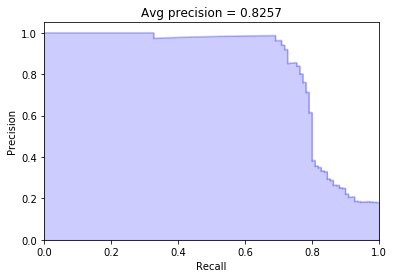

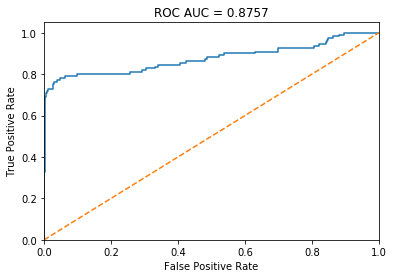

In [17]:
plot_pr_curve(y_val, y_probs)
plt.show()

plot_roc_curve(y_val, y_probs)
plt.show()

## Explainability

In [73]:
import shap
shap.initjs()

In [128]:
t_explainer = shap.TreeExplainer(gbm)
print(t_explainer.expected_value)

shap_values = t_explainer.shap_values(X_val)

[-0.01276027]


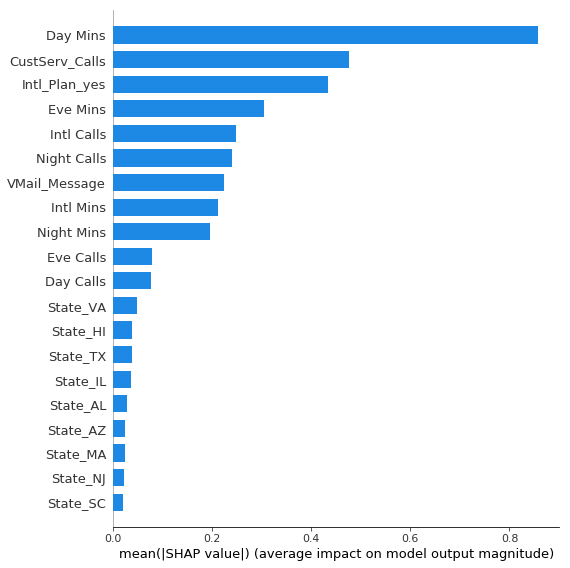

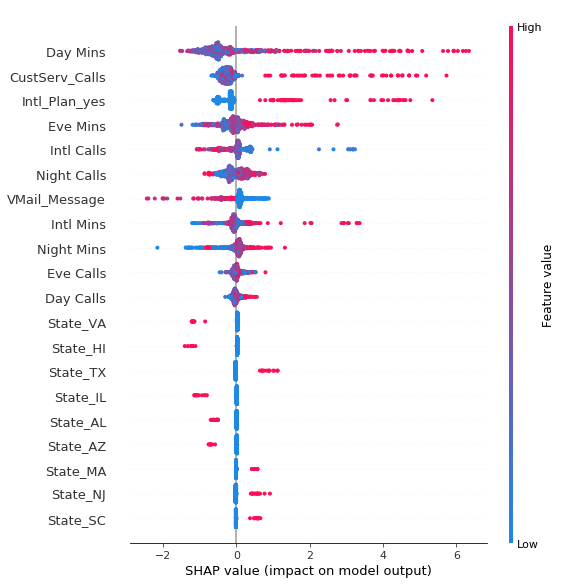

In [129]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_val, plot_type='bar')
shap.summary_plot(shap_values, X_val)

## Test

In [18]:
X_test = test_data.drop('Churn', axis=1)
y_test = test_data['Churn']

In [19]:
y_probs = gbm.predict_proba(X_test)[:,1]

print_results(y_test, y_probs)

Confusion matrix:
[[282   4]
 [  9  39]]
Accuracy: 96.11%
Precision: 90.70%
Recall: 81.25%
F1 score: 85.71%


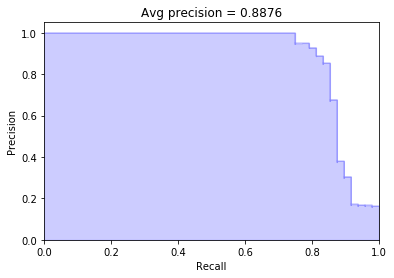

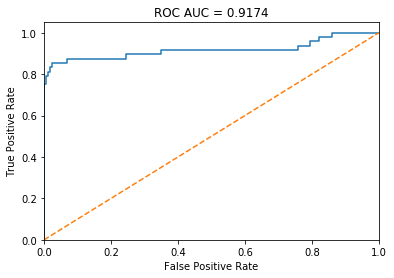

In [20]:
plot_pr_curve(y_test, y_probs)
plt.show()

plot_roc_curve(y_test, y_probs)
plt.show()

# Designing the pipelines: DAG

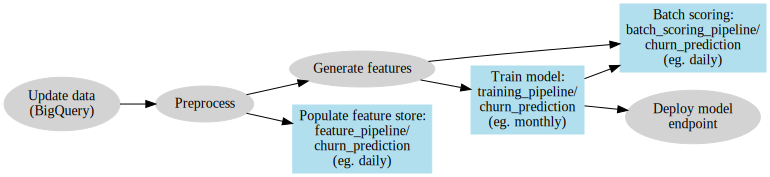

In [1]:
from graphviz import Digraph

dot = Digraph()
dot.node_attr.update(color='lightgrey', style='filled')
dot.graph_attr['rankdir'] = 'LR'
dot.graph_attr['fontsize'] = '8'

dot.node('a', 'Update data\n(BigQuery)')
dot.node('b', 'Preprocess')
dot.node('c', 'Generate features')
dot.node('d', 'Populate feature store:\nfeature_pipeline/\nchurn_prediction\n(eg. daily)',
         shape='rectangle', color='lightblue2', style='filled')
dot.node('e', 'Train model:\ntraining_pipeline/\nchurn_prediction\n(eg. monthly)',
         shape='rectangle', color='lightblue2', style='filled')
dot.node('f', 'Batch scoring:\nbatch_scoring_pipeline/\nchurn_prediction\n(eg. daily)',
         shape='rectangle', color='lightblue2', style='filled')
dot.node('g', 'Deploy model\nendpoint')

dot.edges(['ab', 'bc', 'ce', 'bd', 'cf', 'ef', 'eg'])

dot

In [9]:
dot.format = 'png'
dot.render(filename='flow')

'flow.png'

# Next step: Serving

In [ ]:
sample_row = X_test.values[:1].copy()
gbm.predict_proba(sample_row)[0,1].item()